# Autograd (2)：深度前馈网络——前向传播与反向传播

> 创建时间：2019-12-20

这一份文档将会回顾比较多的内容。

- 第一段中，我们会使用以向量模长为学习目标的模型训练过程，来作最为简单的深度网络模型：多层感知的学习与热身。

- 第二段中，我们会了解网络中的参数如何调取与浏览，并且解释多层感知模型本质上几乎就是普通的矩阵与向量运算，学习前向传播过程。

- 网络参数导数是模型训练过程中非常重要的参考。第三段中，我们会了解网络参数关于损失函数的导数，学习反向传播过程。

In [1]:
import torch
import torch.nn as nn
import numpy as np

from IPython.display import Image

torch.set_printoptions(precision=5, sci_mode=False, linewidth=120)
torch.Tensor.backward.__defaults__ = (None, True, False)

## PyTorch 多层感知 (MLP) 学习向量模长的简易例子

### 小样本学习

相信绝大多数脚本砖工在入门深度学习的时候，都是拿一些现实的问题，譬如 MNIST 数据集或 Iris 数据集来作训练。这可以加深砖工们学习的积极性与目的性，训练的结果也确实可以有效地泛化 (不严格地说，泛化类似于实用化)，固然不错。

但这里尝试用另一种方式来作入门级说明。我们拿一种事实上不太适合深度学习的问题来举例，不管是从问题的意义上还是实用性的角度上。这个问题是用多层感知 (multi-layer perceptron) 模型，学习固定长度 (5 长度) 向量的模长。但这样一个问题非常容易用数学的方式作定义，其训练集与学习目标都是完全可重复、不需要任何先验的知识就可以构建；并且不需要脚本砖工最关心和头疼的数据集处理 (特征向量处理) 的过程。

在 PyTorch 中，这样一个简单的模型 `model` 可以通过下述简单的 layer 堆叠得到：

In [2]:
torch.random.manual_seed(0)
model = nn.Sequential(nn.Linear(5, 4), nn.ReLU(), nn.Linear(4, 3), nn.ReLU(), nn.Linear(3, 1))
model

Sequential(
  (0): Linear(in_features=5, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=1, bias=True)
)

关于上述每一段代码的意义，后文会作更详细的描述。下面的图片就是对上述模型的一个简单描述：

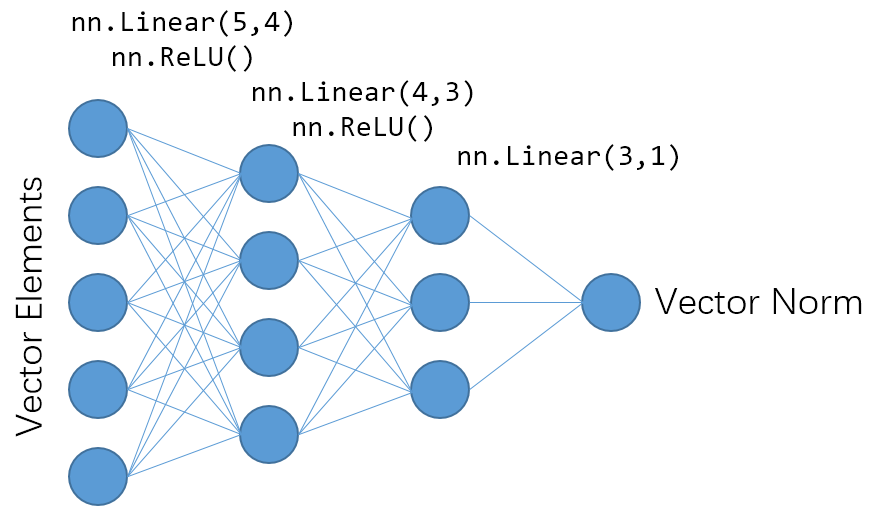

In [3]:
Image(filename="assets/vector_to_norm.png", width=515)

因此，上述网络的输入是 5 长度的向量，通过 MLP 过程，即两层神经网络层 (线性层与激活层的叠加) 与一层线性层后，得到长度为 1 的向量模长。第一层的神经元数量为 4，第二层则为 3。

网络构建完毕后，我们可以构建用于训练的数据集 `X`。

- `X` 的第一维度为 6，意指总共有 6 个数据点用于训练；

- `X` 的第二维度为 5，意指作为特征 (Feature) 或者说数据点的向量长度为 5。

In [4]:
X = torch.randn(6, 5)
X

tensor([[ 0.25963, -0.17396, -0.67875,  0.93826,  0.48887],
        [-0.67309,  0.87283,  1.05536, -0.00479, -0.51807],
        [-0.30670, -1.58099,  1.70664, -0.44622,  2.08196],
        [ 1.70671,  2.38037, -1.12560, -0.31700, -1.09247],
        [-0.08519, -0.09335, -0.76071, -1.59908,  0.01849],
        [-0.75043,  0.18541,  0.62114,  0.63818, -0.24600]])

我们可以很容易地构建该数据集下的真实值 `t`。真实值就是对数据集 `X` 表示数据点的维度 (第二维度) 取模长就得到：

In [5]:
t = X.norm(dim=1, keepdim=True)
t

tensor([[1.29526],
        [1.61155],
        [3.16858],
        [3.33766],
        [1.77540],
        [1.20463]])

在当前简单的问题中，MLP 的意义就是一个拟合映射：

$$
\mathbf{X} \xrightarrow{\text{MLP}} \mathbf{y}
$$

我们定义 `y` 是 MLP 模型下，输入数据 `X` 给出的结果。

我们会希望在参数学习的过程中，`y` 渐渐地接近真实结果 `t`。但在完全没有进行训练的状况下，我们应该会预期这两者的差距会相当大 (我们暂时拿 L1 损失函数来衡量误差)：

In [6]:
y = model(X)
float(nn.L1Loss()(y, t))

1.9639991521835327

若要让 MLP 模型的结果 `y` 接近真实结果 `t`，我们就需要对模型的参数进行优化。下面的代码使用了以下的优化参数：

- 优化器使用 SGD (stochastic gradient descent) (在一般的深度学习问题中，通常大家会更推荐 Adam 优化器)；

- 学习率始终为 0.02；

- 使用 L1 作为损失函数；

- 学习过程中使用梯度下降次数为 1001 次。

但需要指出，实际的深度学习的优化过程的参数是需要一些经验性的手动调整，以及引入验证集等降低泛化误差的做法。下面的代码只是非常简单的实例而已。

In [7]:
optimizer = torch.optim.SGD(model.parameters(), 0.02)

In [8]:
def train(model, X, t, optimizer):
    y = model(X)
    loss = nn.L1Loss()(y, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [9]:
for epoch in range(0, 1001):
    loss = train(model, X, t, optimizer)
    if epoch % 200 == 0:
        print("Loss in epoch {:4d}: {:10.6f}".format(epoch, loss))

Loss in epoch    0:   1.963999
Loss in epoch  200:   0.397570
Loss in epoch  400:   0.049674
Loss in epoch  600:   0.098072
Loss in epoch  800:   0.103638
Loss in epoch 1000:   0.021809


这就完成了一次 MLP 的学习！我们可以看看现在模型作用在训练集上得到的结果 `y`：

In [10]:
model(X)

tensor([[1.24895],
        [1.53482],
        [3.02538],
        [3.18011],
        [1.70085],
        [1.18437]], grad_fn=<AddmmBackward>)

你应该会认为这已经比较接近真实的目标模长值 `t` 了吧。

从刚才训练过程的输出中，我们应当知道训练集的误差大约在 0.02 左右。但这个模型 `model` 是否真的能用于预测任意的长度为 5 的向量的模长呢？答案是不仅否定的，而且刚才的模型甚至会比随机的预测还要糟糕！

下面的代码是取了足够大样本数量 ($1,048,576 = 1024^2$) 来作测试集 `XX_test`，并取另一个取自同一分布的 1,048,576 数量的长度为 5 的向量集合 `Xr_test` 作为随机向量。我们可以经验地认为，对一个向量模长的随机的猜测，可以是与测试集相同分布的另一个随机向量的模长。

如果一个理想的机器学习模型应当要比随机猜测要好许多。但下面的代码显示，随机猜测的误差为 0.78 左右，但模型 `model` 所给出的误差却是 0.91 左右。这意味着模型给出的结果甚至不如瞎蒙！

In [11]:
torch.random.manual_seed(0)
XX_test = torch.randn(1048576, 5)
Xr_test = torch.randn(1048576, 5)
print("Loss for  random guess: {:10.6f}".format(nn.L1Loss()(XX_test.norm(dim=1, keepdim=True), Xr_test.norm(dim=1, keepdim=True))))
print("Loss for trained model: {:10.6f}".format(nn.L1Loss()(model(XX_test), XX_test.norm(dim=1, keepdim=True))))

Loss for  random guess:   0.776423
Loss for trained model:   0.911286


一般来说，对这种现象的解释是，模型的参数较多，而训练集 `X` 的样本数量只有 6 个，因此会发生相当强的过拟合现象。简单粗暴地说来，就是模型会强烈地喜好接近训练集出现的 6 个样本的数据点，而不能很好地处理不太像训练集的数据点。

### 大样本学习

解决上述过拟合问题的一种解决方案是提高训练集数据量。现在我们重启一个从结构上完全等价，但参数的选取可以不同的模型 `model_large`。我们更换一个数据集：这次使用 1024 个样本作为数据集 `X_large` 来学习；并且使用以下的优化参数：

- 优化器使用 Adam；

- 学习率从 0.5 降低到 1e-5，降低的标准为连续 5 次 epoch 损失函数大于最低一次 epoch 损失函数值时，学习率降低到 0.9 倍；

- 使用 L1 作为损失函数；

- 学习过程中使用梯度下降次数为 1001 次。

In [12]:
torch.random.manual_seed(0)
model_large = nn.Sequential(nn.Linear(5, 4), nn.ReLU(), nn.Linear(4, 3), nn.ReLU(), nn.Linear(3, 1))
X_large = torch.randn(1024, 5)
t_large = X_large.norm(dim=1, keepdim=True)

In [13]:
optimizer = torch.optim.Adam(model_large.parameters(), .5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.9, patience=5, min_lr=1e-5)

In [14]:
def train_with_scheduler(model, X, t, scheduler):
    y = model(X)
    loss = nn.L1Loss()(y, t)
    scheduler.optimizer.zero_grad()
    loss.backward()
    scheduler.optimizer.step()
    scheduler.step(loss)
    return loss

In [15]:
for epoch in range(0, 1001):
    loss = train_with_scheduler(model_large, X_large, t_large, scheduler)
    if epoch % 200 == 0:
        print("Loss in epoch {:4d}: {:10.6f}".format(epoch, loss))

Loss in epoch    0:   2.000235
Loss in epoch  200:   0.344131
Loss in epoch  400:   0.308635
Loss in epoch  600:   0.307540
Loss in epoch  800:   0.307498
Loss in epoch 1000:   0.307497


对于上述学得的模型 `model_large`，我们发现其训练集上的误差约为 0.31，明显比小样本学习中的 0.02 要大许多；但在相同的测试集中，其误差却降低到 0.35 左右。这意味着 `model_large` 尽管仍然不能很好地预测向量的模长，但至少已经比随机猜测好许多。

In [16]:
print("Loss for  random guess: {:10.6f}".format(nn.L1Loss()(XX_test.norm(dim=1, keepdim=True), Xr_test.norm(dim=1, keepdim=True))))
print("Loss for trained model: {:10.6f}".format(nn.L1Loss()(model_large(XX_test), XX_test.norm(dim=1, keepdim=True))))

Loss for  random guess:   0.776423
Loss for trained model:   0.352113


在这种模型下，训练集与测试集的误差都不算太小但比较接近。一般认为这种情况已经有效地解决过拟合的效应，但存在相当严重的欠拟合效应。欠拟合效应反映的是模型本身的缺陷。

在这个例子中，这意味着 `model_large` 的参数不论如何学习，恐怕都无法作出有效的预测。一般来说会有效的解决方案可以是增大模型的大小 (反映在增加 MLP 神经元数量与层的数量)，或干脆更换一套模型框架。

如何解决当前例子的欠拟合问题，不在这个文档的讨论范畴之内。

## PyTorch 普通前馈网络的定义

### 段落目标：重复模型过程

刚才我们花了不少精力，除了展示一个比较简单易行、但比较完整的深度学习流程之外，更重要的目的是说明了这篇文档的模型与数据。

后面的文档中，我们将会拿上面提到过的小样本模型 `model` 与数据集 `X`，来探讨 PyTorch 中 MLP 层具体是怎样计算，以及如何进行自动求导以更新参数表。这一段中我们先会解决前一个问题。我们的目标是，对于任何学习过最基础矩阵运算的人，都可以很轻易地理解到在给定参数的情况下，MLP 的前向传播过程不同于很多机器学习模型，在本质上仅仅是由非常简单的矩阵运算构成的。

在解决问题前，我们先将模型换为没有经过训练的状况。这么做的目的单纯地是为了让梯度变得大一些，以便后面比较有效的定性与定量分析。

In [17]:
torch.random.manual_seed(0)
model = nn.Sequential(nn.Linear(5, 4), nn.ReLU(), nn.Linear(4, 3), nn.ReLU(), nn.Linear(3, 1))

我们代入的训练集是 (6, 5) 的矩阵 `X` $\mathbf{X}$；其第一维度为数据点数量，第二维度为特征向量长度。

In [18]:
X = torch.randn(6, 5)
X

tensor([[ 0.25963, -0.17396, -0.67875,  0.93826,  0.48887],
        [-0.67309,  0.87283,  1.05536, -0.00479, -0.51807],
        [-0.30670, -1.58099,  1.70664, -0.44622,  2.08196],
        [ 1.70671,  2.38037, -1.12560, -0.31700, -1.09247],
        [-0.08519, -0.09335, -0.76071, -1.59908,  0.01849],
        [-0.75043,  0.18541,  0.62114,  0.63818, -0.24600]])

在模型的作用下，得到的结果是 (6, 1) 的矩阵向量 `y` $\mathbf{y}$，其第一维度为数据点数量。

In [19]:
y = model(X)
y

tensor([[0.05652],
        [0.11903],
        [0.10917],
        [0.10579],
        [0.10462],
        [0.11395]], grad_fn=<AddmmBackward>)

我们的目标是用普通的、容易理解的矩阵过程重新描述 `layer(X)`。

### 模型参数

模型 `model` 的定义是通过参数给出的。这些参数在 PyTorch 中以字典的形式储存在 `state_dict` 方法下：

In [20]:
param = model.state_dict()
type(param)

collections.OrderedDict

这意味着这些参数是可以被读取的。由于这个模型并不庞大，我们可以打出所有的参数数值以及它们在字典中对应的键值来。我们还可以同时计算出这个模型的参数总量为 43。

In [21]:
parameter_number = 0

for name, tensor in param.items():
    print("------")
    print("KEY:", name)
    print("shape:", tuple(tensor.shape))
    print(tensor)
    parameter_number += torch.prod(torch.tensor(tensor.shape))
    
print("======")
print("Parameter number:", int(parameter_number))

------
KEY: 0.weight
shape: (4, 5)
tensor([[-0.00335,  0.23990, -0.36808, -0.32912, -0.17225],
        [ 0.11992, -0.00886,  0.35459, -0.03969,  0.11834],
        [-0.13515, -0.08791, -0.42724, -0.29618, -0.18435],
        [ 0.01657,  0.17680,  0.26834, -0.30318, -0.19474]])
------
KEY: 0.bias
shape: (4,)
tensor([ 0.16244,  0.37136, -0.09204,  0.33466])
------
KEY: 2.weight
shape: (3, 4)
tensor([[-0.08059,  0.05291,  0.45274, -0.46384],
        [-0.31477, -0.12658, -0.19490,  0.43200],
        [-0.32409, -0.23017, -0.34932, -0.46828]])
------
KEY: 2.bias
shape: (3,)
tensor([-0.29187,  0.42980,  0.22311])
------
KEY: 4.weight
shape: (1, 3)
tensor([[ 0.27983,  0.03036, -0.29600]])
------
KEY: 4.bias
shape: (1,)
tensor([0.09768])
Parameter number: 43


如果我们希望取出其中第一个矩阵 `0.weight`，我们可以用下述代码：

In [22]:
param["0.weight"]

tensor([[-0.00335,  0.23990, -0.36808, -0.32912, -0.17225],
        [ 0.11992, -0.00886,  0.35459, -0.03969,  0.11834],
        [-0.13515, -0.08791, -0.42724, -0.29618, -0.18435],
        [ 0.01657,  0.17680,  0.26834, -0.30318, -0.19474]])

使用 `model.state_dict()` 是比较标准的取出参数表的方法；我们之后为了能对参数进行导数计算，这里换用 `model.named_parameters()` 取出参数，并使用其它变量名替代其中的参数：

In [23]:
param = {}
for i in model.named_parameters():
    param[i[0]] = i[1]
W_0, b_0 = param["0.weight"], param["0.bias"]
W_2, b_2 = param["2.weight"], param["2.bias"]
W_4, b_4 = param["4.weight"], param["4.bias"]

现在我们要解决如下的几个问题。

第一个问题是，键值的名称是如何被定义的。我们现在先回头看一下模型 `model` 是如何定义的：

In [24]:
model

Sequential(
  (0): Linear(in_features=5, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=1, bias=True)
)

这就意味着，在 PyTorch 中，程序认定这个模型当前是 5 层 (而不是我们刚才提到的 MLP 的 2 层神经元的层数)；其中第 0, 2, 4 层是线性层，1, 3 层是 ReLU 激活层。一般来说，一层神经元是指一层线性层叠加一层激活层；因此我们会说第一层神经元对应 `model` 的 0, 1 层，而第二层神经元对应 `model` 的第 2, 3 层。之后我们通常在提到“层”的时候，指的是程序中出现的 5 层。

其中具有参数的层只有线性层。`W_0` 表示的是第 0 层的权重 $\mathbf{W}^0$，而 `b_0` 表示第 0 层的偏置 $\mathbf{b}^0$。第 2, 4 层类推。留意在这篇文档中，上标数字并不代表矩阵或向量的幂运算。

第二个问题是，每个参数值的维度是如何被定义的。

我们仍然需要回头看一下 `model` 的定义。以第 0 层为例，其输入特征长度 `in_features` 为 5，这与 `X` $\mathbf{X}$ 的维度是相同；而其输出特征长度 `out_features` 为 4。另一个例子是最后一层即第 4 层，其输出特征长度 `out_features` 为 1，这与 `y` $\mathbf{y}$ 的维度是相同。

对于任何线性层而言，其权重矩阵的维度为 (`out_features`, `in_features`)；其偏置向量的维度为 (`out_features`, )。以第 0 层为例，

In [25]:
W_0.shape

torch.Size([4, 5])

In [26]:
b_0.shape

torch.Size([4])

关于权重矩阵与偏置向量，它们的作用将会马上在下一段介绍。

### 线性层

现在我们简单地了解一下第 0 层线性层的作用。实际上，线性层的作用是相当简单的：

$$
\mathbf{X}^0 = \mathbf{X} \mathbf{W}^{0,\mathrm{T}} + \mathbf{b}^0
$$

上面的记号中，`X_0` $\mathbf{X}^0$ 表示第 0 层输出矩阵，`X` $\mathbf{X}$ 表示第 0 层输入矩阵 (恰好为数据集)，`W_0` $\mathbf{W}^{0}$ 表示第 0 层作为线性层的权重矩阵，`b_0` $\mathbf{b}^0$ 表示第 0 层作为线性层的偏置向量。上标 $\mathrm{T}$ 表示矩阵转置。

In [27]:
X_0 = X @ param["0.weight"].T + param["0.bias"]
X_0

tensor([[-0.02335,  0.18398, -0.18986, -0.25360],
        [ 0.07644,  0.59601, -0.43176,  0.86336],
        [-1.05575,  1.21783, -0.89241,  0.23785],
        [ 1.43460,  0.03912,  0.24424,  0.79060],
        [ 0.94343,  0.15788,  0.72290,  0.59383],
        [-0.18687,  0.44553, -0.41596,  0.37610]], grad_fn=<AddBackward0>)

但上述矩阵的表示相对来说不太直观；一种相对来说直观的方式可以是 (但不是标准的表示方法，只是作者写多了化学反应式自然会生成的一种习惯)

$$
\mathbf{X} \xrightarrow{\text{Linear} (5, 4)} \mathbf{X}^0
$$

对于第 2, 4 层线性层，其过程是非常类似的：

$$
\begin{align}
\mathbf{X}^1 &\xrightarrow{\text{Linear} (4, 3)} \mathbf{X}^2 \\
\mathbf{X}^3 &\xrightarrow{\text{Linear} (3, 1)} \mathbf{X}^4 = \mathbf{y}
\end{align}
$$

### 激活层

MLP 的线性层一般就是普通的矩阵乘法，但激活层的选取可以较为丰富。一种典型与常用的激活层是 ReLU (Rectified Linear Unit)，其定义非常简单：

$$
\mathrm{ReLU} (x) = \max(x, 0)
$$

因此，若我们记 `X_0` $\mathbf{X}^0$ 表示第 0 层输出矩阵，`X_1` $\mathbf{X}^0$ 表示第 1 层输出矩阵；那么

$$
\mathbf{X}^1 = \mathrm{ReLU} (\mathbf{X}^0) = \max(\mathbf{X}^0, \mathbf{0})
$$

若联合线性层，其比较直观的表示方式为

$$
\begin{align}
\mathbf{X} &\xrightarrow[\mathrm{ReLU}]{\text{Linear} (5, 4)} \mathbf{X}^1 \\
\mathbf{X}^1 &\xrightarrow[\mathrm{ReLU}]{\text{Linear} (4, 3)} \mathbf{X}^3
\end{align}
$$

对于程序的实现上，`X_1` 可以表示为

In [28]:
X_1 = torch.max(X_0, torch.tensor(0.))
X_1

tensor([[0.00000, 0.18398, 0.00000, 0.00000],
        [0.07644, 0.59601, 0.00000, 0.86336],
        [0.00000, 1.21783, 0.00000, 0.23785],
        [1.43460, 0.03912, 0.24424, 0.79060],
        [0.94343, 0.15788, 0.72290, 0.59383],
        [0.00000, 0.44553, 0.00000, 0.37610]], grad_fn=<MaxBackward2>)

### 总结

现在我们可以写出 `model` 模型下，从 $\mathbf{X}$ 到 $\mathbf{y}$ 的流程：

$$
\mathbf{X}
\xrightarrow[\mathrm{ReLU}]{\text{Linear} (5, 4)} \mathbf{X}^1
\xrightarrow[\mathrm{ReLU}]{\text{Linear} (4, 3)} \mathbf{X}^3
\xrightarrow{\text{Linear} (3, 1)} \mathbf{X}^4 = \mathbf{y}
$$

若要写出每一步的详细过程，则可以是

$$
\begin{align}
\mathbf{X}^0 &= \mathbf{X} \mathbf{W}^{0,\mathrm{T}} + \mathbf{b}^0 \\
\mathbf{X}^1 &= \max (\mathbf{X}^0, \mathbf{0}) \\
\mathbf{X}^2 &= \mathbf{X}^1 \mathbf{W}^{2,\mathrm{T}} + \mathbf{b}^2 \\
\mathbf{X}^3 &= \max (\mathbf{X}^2, \mathbf{0}) \\
\mathbf{y} = \mathbf{X}^4 &= \mathbf{X}^3 \mathbf{W}^{4,\mathrm{T}} + \mathbf{b}^4
\end{align}
$$

我们将上述矩阵的计算操作结果记作 `X_4` $\mathbf{X}^4$，而仍然将 `model(X)` 的结果记作 `y` $\mathbf{y}$。我们可以发现这两者是完全等价的：

In [29]:
X_0 = X   @ param["0.weight"].T + param["0.bias"]
X_1 = torch.max(X_0, torch.tensor(0.))
X_2 = X_1 @ param["2.weight"].T + param["2.bias"]
X_3 = torch.max(X_2, torch.tensor(0.))
X_4 = X_3 @ param["4.weight"].T + param["4.bias"]
X_4

tensor([[0.05652],
        [0.11903],
        [0.10917],
        [0.10579],
        [0.10462],
        [0.11395]], grad_fn=<AddBackward0>)

In [30]:
y

tensor([[0.05652],
        [0.11903],
        [0.10917],
        [0.10579],
        [0.10462],
        [0.11395]], grad_fn=<AddmmBackward>)

如果我们希望在一个公式内解决一切与 $\mathbf{X}$ 到 $\mathbf{y}$ 的映射，我们可以写作

$$
\mathbf{X} \xrightarrow{\text{MLP}} \mathbf{y} \Leftrightarrow
\mathbf{y} = \mathbf{X}^4 = \max \left[ \max (\mathbf{X} \mathbf{W}^{0,\mathrm{T}} + \mathbf{b}^0, \mathbf{0}) \mathbf{W}^{2,\mathrm{T}} + \mathbf{b}^2, \mathbf{0} \right] \mathbf{W}^{4,\mathrm{T}} + \mathbf{b}^4
$$

In [31]:
X_4 = torch.max(torch.max(
    X @ param["0.weight"].T + param["0.bias"],
    torch.tensor(0.)) @ param["2.weight"].T + param["2.bias"],
    torch.tensor(0.)) @ param["4.weight"].T + param["4.bias"]
X_4

tensor([[0.05652],
        [0.11903],
        [0.10917],
        [0.10579],
        [0.10462],
        [0.11395]], grad_fn=<AddBackward0>)

至此，我们已经成功地用简单的矩阵运算还原了 PyTorch 封装过的 MLP 模型 `model` 了。这是可以是一个比较典型的模型重复的标准途径，也将会对文档第三部分了解模型的反向传播过程有重要的意义。

## MLP 参数导数

### 被求导对象

这里我们就以这个非常短小、但是需要使用链式法则进行反向传播的 MLP 模型 `model` 进行分析。我们的目标是与 PyTorch 的 Autograd 的结果进行核对。但我们在上一份文档中提到，任何函数的导数都必须转化为标量的导数；即使输出并非是标量，也必须乘以与输出相同维度的张量并作求和得到变量。

对于当前的问题而言，作为标量的值是输出 `y` $\mathbf{y}$ 与真实值 `t` $\mathbf{t}$ 的 L1 损失函数值 `loss` $\mathrm{loss}$：

$$
\mathrm{loss} = \Vert \mathbf{y} - \mathbf{t} \Vert_1
$$

In [32]:
loss = nn.L1Loss()(y, t)
loss

tensor(1.96400, grad_fn=<L1LossBackward>)

这一段的分析都是基于 `loss` 的导数得到。对该值的导数可以通过下述方式得到：

In [33]:
model.zero_grad()
loss.backward()
print("grad of W_0"); print(W_0.grad)
print("grad of b_0"); print(b_0.grad)
print("grad of W_2"); print(W_2.grad)
print("grad of b_2"); print(b_2.grad)
print("grad of W_4"); print(W_4.grad)
print("grad of b_4"); print(b_4.grad)

grad of W_0
tensor([[ 0.00151,  0.00503, -0.00132, -0.00306, -0.00254],
        [-0.00285,  0.00299,  0.00823, -0.01116, -0.00508],
        [ 0.00160,  0.00226, -0.00186, -0.00189, -0.00106],
        [ 0.00024, -0.00386, -0.00327,  0.00378, -0.00053]])
grad of b_0
tensor([ 0.00478, -0.00751,  0.00197, -0.01093])
grad of W_2
tensor([[ 0.00000,  0.00000,  0.00000,  0.00000],
        [-0.01242, -0.01336, -0.00489, -0.01448],
        [ 0.00000,  0.00908,  0.00000,  0.00000]])
grad of b_2
tensor([ 0.00000, -0.03036,  0.04933])
grad of W_4
tensor([[ 0.00000, -0.41996, -0.03013]])
grad of b_4
tensor([-1.])


### 第 4 层参数导数：非参数矩阵引入

在所有的参数中，最容易求的导数在最后一层。我们将 `loss` $\mathrm{loss}$ 写为第 2 层参数的函数：

$$
\mathrm{loss} = \Vert \mathbf{X}^3 \mathbf{W}^{4, \mathrm{T}} + \mathbf{b}^4 - \mathbf{t} \Vert_1
$$

In [34]:
(X_3 @ W_4.T + b_4 - t).abs().sum() / t.shape[0]

tensor(1.96400, grad_fn=<DivBackward0>)

但从公式的表达角度上，上面的表达式不太容易被求导。在此，我们引入第 5 层非参数矩阵 `l_5` $\mathbf{l}^5 = \mathrm{dim} (\mathbf{y})^{-1} \mathrm{sgn} (\mathbf{y} - \mathbf{t})$，那么

$$
\mathrm{loss} = \mathbf{l}^{5, \mathrm{T}} \left( \mathbf{X}^3 \mathbf{W}^{4, \mathrm{T}} + \mathbf{b}^4 - \mathbf{t} \right)
$$

或表示为矩阵元的形式，

$$
\mathrm{loss} = \sum_{ij} l_{i0}^{5} \left( X_{ij}^3 W_{0j}^{4} + b_0^4 - t_{i0} \right)
$$

上式中出现的 $0$ 表示该维度恰好为 1 维。

In [35]:
l_5 = (y - t).sign() / y.shape[0]
l_5.shape

torch.Size([6, 1])

In [36]:
l_5.T @ (X_3 @ W_4.T + b_4 - t)

tensor([[1.96400]], grad_fn=<MmBackward>)

根据上面公式的表述，我们就可以比较容易地给出关于 $\mathbf{W}^{4, \mathrm{T}}$ 的导数

$$
\frac{\partial \mathrm{loss}}{\partial \mathbf{W}^{4}} = \mathbf{l}^{5, \mathrm{T}} \mathbf{X}^3
$$

或矩阵元的形式

$$
\frac{\partial \mathrm{loss}}{\partial W_{0j}^{4}} = \sum_{i} l_{i0}^{5} X_{ij}^3
$$

我们可以将其 `gW_4` 与 PyTorch 自动导数给出的 `W_4.grad` 进行比对：

In [37]:
gW_4 = l_5.T @ X_3
torch.allclose(gW_4, W_4.grad)

True

但这里需要指出，由于 $\mathbf{b}^4$ 作为偏置矩阵的维度与其它矩阵不太相同，因此在求梯度时，需要对 $\mathbf{l}^{5, \mathrm{T}}$ 的第一维度，或者说对表示数据点数量的维度求和：

$$
\frac{\partial \mathrm{loss}}{\partial b_0^4} = \sum_{i} l_{i0}^{5}
$$

我们可以将其 `gb_4` 与 PyTorch 自动导数给出的 `b_4.grad` 进行比对：

In [38]:
gb_4 = l_5.T.sum(dim=-1)
torch.allclose(gb_4, b_4.grad)

True

### 第 2 层参数导数：链式法则

第二层参数的导数会复杂不少。如果我们把 `loss` $\mathrm{loss}$ 写为第 2 层参数的函数：

$$
\mathrm{loss} = \mathbf{l}^{5, \mathrm{T}} \left( \mathrm{ReLU} \left( \mathbf{X}^1 \mathbf{W}^{2, \mathrm{T}} + \mathbf{b}^2 \right) \mathbf{W}^{4, \mathrm{T}} + \mathbf{b}^4 - \mathbf{t} \right)
$$

In [39]:
l_5.T @ (nn.ReLU()(X_1 @ W_2.T + b_2) @ W_4.T + b_4 - t)

tensor([[1.96400]], grad_fn=<MmBackward>)

如果要尝试对 $\mathbf{W}^{2}$ 或 $\mathbf{b}^2$ 求导，我们又会遇到与刚才第四层导数相同的问题，即如何对 $\mathrm{ReLU}$ 求导。我们引入第 3 层非参数矩阵 `l_3` $\mathbf{l}^3 = \mathrm{sgn}^+ (\mathbf{X}^{2})$：

$$
\begin{align}
\mathrm{loss}
&= \mathbf{l}^{5, \mathrm{T}} \left( \mathbf{X}^3 \mathbf{W}^{4, \mathrm{T}} + \mathbf{b}^4 - \mathbf{t} \right) \\
&= \mathbf{l}^{5, \mathrm{T}} \left( \mathbf{l}^3 \odot \left( \mathbf{X}^1 \mathbf{W}^{2, \mathrm{T}} + \mathbf{b}^2 \right) \mathbf{W}^{4, \mathrm{T}} + \mathbf{b}^4 - \mathbf{t} \right)
\end{align}
$$

或表示为矩阵元的形式，

$$
\begin{align}
\mathrm{loss}
&= \sum_{ij} l_{i0}^{5} \left( X_{ij}^3 W_{0j}^{4} + b_0^4 - t_{i0} \right) \\
&= \sum_{ijk} l_{i0}^{5} \left( l_{ij}^3 (X_{ik}^1 W_{jk}^2 + b_{j}^2) W_{0j}^{4} + b_0^4 - t_{i0} \right)
\end{align}
$$

其中，记号 $\mathrm{sgn}^+$ 表示正值取 1，负值取 0：

$$
\mathrm{sgn}^+ (x) = \max( \mathrm{sgn} (x), 0 )
$$

上面的计算过程中，矩阵 elementwise 乘法与普通的矩阵乘法的运算优先级是相同的。

In [40]:
sgn_pos = lambda t: torch.max(t.sign(), torch.tensor(0.))

In [41]:
l_3 = sgn_pos(X_2)
l_3.shape

torch.Size([6, 3])

In [42]:
l_5.T @ (l_3 * (X_1 @ W_2.T + b_2) @ W_4.T + b_4 - t)

tensor([[1.96400]], grad_fn=<MmBackward>)

我们固然可以对上式直接求关于 $\mathbf{W}^{2}$ 参数的导数得到 `gW_2`，并与 PyTorch 自动求导给出的 `W_2.grad` 进行比对：

$$
\frac{\partial \mathrm{loss}}{\partial \mathbf{W}^{2}} = \mathbf{W}^{4, \mathrm{T}} \mathbf{l}^{5, \mathrm{T}} \odot \mathbf{l}^{3, \mathrm{T}} \mathbf{X}^1
$$

或

$$
\frac{\partial \mathrm{loss}}{\partial W_{jk}^2} = \sum_{i} l_{ij}^3 (X_{ik}^1 W_{jk}^2 + b_{j}^2) W_{0j}^{4}
$$

In [43]:
gW_2 = W_4.T @ l_5.T * l_3.T @ X_1
torch.allclose(gW_2, W_2.grad)

True

但我们可以有更为精妙的做法 (或者说思考方法)。注意到我们可以将 $\mathrm{loss}$ 看成关于 $\mathbf{X}^3$ 的函数，而 $\mathbf{X}^3$ 又可以看作是关于 $\mathbf{W}^2$ 的函数：

$$
\begin{align}
\mathbf{X}^3 &= \mathbf{l}^3 \odot \left( \mathbf{X}^1 \mathbf{W}^{2, \mathrm{T}} + \mathbf{b}^2 \right) \\
\mathrm{loss} &= \mathbf{l}^{5, \mathrm{T}} \left( \mathbf{X}^3 \mathbf{W}^{4, \mathrm{T}} + \mathbf{b}^4 - \mathbf{t} \right)
\end{align}
$$

或

$$
\begin{align}
X_{ij}^3 &= \sum_{k} l_{ij}^3 (X_{ik}^1 W_{jk}^2 + b_{j}^2) \\
\mathrm{loss} &= \sum_{ij} l_{i0}^{5} \left( X_{ij}^3 W_{0j}^{4} + b_0^4 - t_{i0} \right) \\
\end{align}
$$

那么，我们就可以分别写出导数

$$
\begin{align}
\frac{\partial \mathrm{loss}}{\partial X_{ij}^3} &= l_{i0}^{5} W_{0j}^{4} \\
\frac{\partial X_{ij}^3}{\partial W_{jk}^2} &= l_{ij}^3 X_{ik}^1
\end{align}
$$

我们定义 $\frac{\partial \mathrm{loss}}{\partial X_{ij}^3}$ 在程序中表示为 `gX_3`。依据链式法则，我们就可以给出

$$
\frac{\partial \mathrm{loss}}{\partial W_{jk}^2} = \sum_i \frac{\partial \mathrm{loss}}{\partial X_{ij}^3} \frac{\partial X_{ij}^3}{\partial W_{jk}^2} = \sum_i \frac{\partial \mathrm{loss}}{\partial X_{ij}^3} l_{ij}^3 X_{ik}^1
$$

拿上式与 PyTorch 自动求导给出的 `W_2.grad` 进行比对也能得到正确的结果：

In [44]:
gX_3 = l_5 @ W_4
gW_2 = gX_3.T * l_3.T @ X_1
torch.allclose(gW_2, W_2.grad)

True

而对于 $\mathbf{b}^2$ 的导数 `gb_2` 的情况也会非常类似：

$$
\frac{\partial \mathrm{loss}}{\partial b_{j}^2} = \sum_i \frac{\partial \mathrm{loss}}{\partial X_{ij}^3} \frac{\partial X_{ij}^3}{\partial b_{j}^2} = \sum_i \frac{\partial \mathrm{loss}}{\partial X_{ij}^3} l_{ij}^3
$$

In [45]:
gb_2 = (gX_3.T * l_3.T).sum(dim=-1)
torch.allclose(gb_2, b_2.grad)

True

我们也许在这个例子中没有感受到链式法则的意义；即使不使用链式法则，程序的复杂性也没有增大许多。但对于 $\mathbf{W}^0$ 与 $\mathbf{b}^0$，使用链式法则的意义就会表现出来。

### 第 0 层参数导数：反向传播

上面一小段中，在求导过程中我们使用了一次链式法则。下面我们会比较系统地，从头回顾，将问题一步一步拆分，从而获得第 0 层参数 $\mathbf{W}^0$ 与 $\mathbf{b}^0$ 的导数。

$$
\begin{align}
\mathbf{X}^0 &= \mathbf{X} \mathbf{W}^{0,\mathrm{T}} + \mathbf{b}^0 \tag{0} \\
\mathbf{X}^1 &= \mathbf{l}^1 \odot \mathbf{X}^0 \tag{1} \\
\mathbf{X}^2 &= \mathbf{X}^1 \mathbf{W}^{2,\mathrm{T}} + \mathbf{b}^2 \tag{2} \\
\mathbf{X}^3 &= \mathbf{l}^3 \odot \mathbf{X}^2 \tag{3} \\
\mathbf{X}^4 &= \mathbf{X}^3 \mathbf{W}^{4,\mathrm{T}} + \mathbf{b}^4 \tag{4} \\
\mathrm{loss} &= \mathbf{l}^{5, \mathrm{T}} \left( \mathbf{X}^4 - \mathbf{t} \right) \tag{5}
\end{align}
$$

上述的表示在写程序时可能是方便的，但在分析时，容易会对维度的信息把握得不太好。我们在此将下标明确地写出：

$$
\begin{align}
X^0_{ik} &= \sum_l X_{il} W^0_{kl} + b^0_{k} \tag{0} \\
X^1_{ik} &= l^1_{ik} X^0_{ik} \tag{1} \\
X^2_{ij} &= \sum_k X^1_{ik} W^2_{jk} + b^2_{j} \tag{2} \\
X^3_{ij} &= l^3_{ij} X^2_{ij} \tag{3} \\
X^4_{i0} &= \sum_j X^3_{ij} W^4_{0j} + b^4_{0} \tag{4} \\
\mathrm{loss} &= \sum_i l^5_{i0} (X^4_{i0} - t_{i0}) \tag{5}
\end{align}
$$

其中的第 1, 3, 5 层引入了非参数矩阵，它们的定义为

$$
\begin{align}
l^1_{ik} &= \mathrm{sgn}^+ (X^0_{ik}) \\
l^3_{ij} &= \mathrm{sgn}^+ (X^2_{ij}) \\
l^5_{i0} &= \mathrm{dim} (i)^{-1} \mathrm{sgn} (X^4_{i0} - t_{i0})
\end{align}
$$

In [46]:
l_1 = sgn_pos(X_0)
l_3 = sgn_pos(X_2)
l_5 = y.shape[0]**-1 * (y - t).sign()

我们的目标是第 0 层参数导数 $\mathbf{W}^0$ 与 $\mathbf{b}^0$，但我们的被求导对象 $\mathrm{loss}$ 在第 5 层。反向传播的一种解读方式是，导数的求取是从最后层向前传播。那么我们一层一层地对导数进行求取。

**第 5 层** `gX_4` $\frac{\partial \mathrm{loss}}{\partial X^4_{i0}}$

$$
\frac{\partial \mathrm{loss}}{\partial X^4_{i0}} = l^5_{i0}
$$

In [47]:
gX_4 = l_5

**第 4 层** `gX_3` $\frac{\partial \mathrm{loss}}{\partial X^3_{ij}}$

$$
\frac{\partial X^4_{i0}}{\partial X^3_{ij}} = W^4_{0j}, \quad
\frac{\partial \mathrm{loss}}{\partial X^3_{ij}} = \frac{\partial \mathrm{loss}}{\partial X^4_{i0}} \frac{\partial X^4_{i0}}{\partial X^3_{ij}} = \frac{\partial \mathrm{loss}}{\partial X^4_{i0}} W^4_{0j}
$$

In [48]:
gX_3 = gX_4 @ W_4

**第 3 层** `gX_2` $\frac{\partial \mathrm{loss}}{\partial X^2_{ij}}$

$$
\frac{\partial X^3_{ij}}{\partial X^2_{ij}} = l^3_{ij}, \quad
\frac{\partial \mathrm{loss}}{\partial X^2_{ij}} = \frac{\partial \mathrm{loss}}{\partial X^3_{ij}} \frac{\partial X^3_{ij}}{\partial X^2_{ij}} = \frac{\partial \mathrm{loss}}{\partial X^3_{ij}} l^3_{ij}
$$

In [49]:
gX_2 = gX_3 * l_3

**第 2 层** `gX_1` $\frac{\partial \mathrm{loss}}{\partial X^1_{ik}}$

$$
\frac{\partial X^2_{ij}}{\partial X^1_{ik}} = W^2_{jk}, \quad
\frac{\partial \mathrm{loss}}{\partial X^1_{ik}} = \sum_j \frac{\partial \mathrm{loss}}{\partial X^2_{ij}} \frac{\partial X^2_{ij}}{\partial X^1_{ik}} = \sum_j \frac{\partial \mathrm{loss}}{\partial X^2_{ij}} W^2_{jk}
$$

In [50]:
gX_1 = gX_2 @ W_2

**第 1 层** `gX_0` $\frac{\partial \mathrm{loss}}{\partial X^0_{ik}}$

$$
\frac{\partial X^1_{ik}}{\partial X^0_{ik}} = l^1_{ik}, \quad
\frac{\partial \mathrm{loss}}{\partial X^0_{ik}} = \frac{\partial \mathrm{loss}}{\partial X^1_{ik}} \frac{\partial X^1_{ik}}{\partial X^0_{ik}} = \frac{\partial \mathrm{loss}}{\partial X^1_{ik}} l^1_{ik}
$$

In [51]:
gX_0 = gX_1 * l_1

**第 0 层**

`gW_0` $\frac{\partial \mathrm{loss}}{\partial W^0_{kl}}$

$$
\frac{\partial X^0_{ik}}{\partial W^0_{kl}} = X_{il}, \quad
\frac{\mathrm{loss}}{\partial W^0_{kl}} = \sum_i \frac{\mathrm{loss}}{\partial X^0_{ik}} \frac{\partial X^0_{ik}}{\partial W^0_{kl}} = \sum_i \frac{\mathrm{loss}}{\partial X^0_{ik}} X_{il}
$$

In [52]:
gW_0 = gX_0.T @ X
torch.allclose(gW_0, W_0.grad)

True

`gb_0` $\frac{\partial \mathrm{loss}}{\partial b^0_{k}}$

$$
\frac{\partial X^0_{ik}}{\partial b^0_{k}} = 1, \quad
\frac{\mathrm{loss}}{\partial b^0_{k}} = \sum_i \frac{\mathrm{loss}}{\partial X^0_{ik}} \frac{\partial X^0_{ik}}{\partial b^0_{k}} = \sum_i \frac{\mathrm{loss}}{\partial X^0_{ik}}
$$

In [53]:
gb_0 = gX_0.sum(dim=0)
torch.allclose(gb_0, b_0.grad)

True

至此我们已经成功地使用了反向传播的方法，对最难求解的 $\mathbf{W}^0$ 与 $\mathbf{b}^0$ 的参数进行了导数求取。这样一个过程可以是非常清晰与规范化的。

对于该模型更简单的其它参数，或者对于层数更多的 MLP 网络，使用完全相同的方式也能生成所有的导数。

我们知道，深度网络的参数优化过程通常是梯度下降的衍生方法。如果知道了这些参数的导数量，我们至少相信可以很自然地写出一个 naive 梯度下降优参的程序，实现深度网络的学习。